In [1]:
import numpy as np

from app.data_utils import create_df
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = create_df('../../files/NYPD_Complaint_Data_Historic.csv')

In [3]:
df.head(7)

,CMPLNT_FR,BORO_NM,PREM_TYP_DESC,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,Latitude,Longitude
0,2018-03-29 20:30:00,MANHATTAN,PARKING LOT/GARAGE (PUBLIC),25-44,WHITE,F,NaN,NaN,NaN,40.810877,-73.941064
1,2018-02-06 23:15:00,BRONX,DEPARTMENT STORE,UNKNOWN,UNKNOWN,D,45-64,BLACK,F,40.873671,-73.908014
2,2018-11-21 00:15:00,BROOKLYN,STREET,UNKNOWN,UNKNOWN,D,25-44,WHITE,F,40.651782,-73.885457
3,2018-06-09 21:42:00,MANHATTAN,RESIDENCE - APT. HOUSE,18-24,WHITE,F,25-44,WHITE,M,40.759310,-73.994706
4,2018-11-10 19:40:00,MANHATTAN,CHAIN STORE,UNKNOWN,UNKNOWN,D,<18,BLACK,F,40.764536,-73.970728
5,2018-03-12 11:48:00,MANHATTAN,TRANSIT - NYC SUBWAY,UNKNOWN,UNKNOWN,E,NaN,NaN,NaN,40.804384,-73.937422
6,2013-04-07 16:00:00,QUEENS,STREET,NaN,UNKNOWN,E,NaN,NaN,NaN,40.703555,-73.799677


In [4]:
df = df.set_index(["CMPLNT_FR"])
crime_dates = df.index.value_counts().to_frame('count')

<AxesSubplot:>

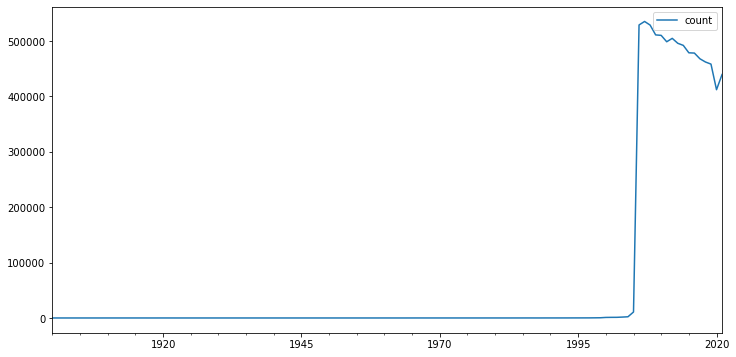

In [5]:
crime_dates['count'].resample('Y').sum().to_frame('count').plot(figsize=(12, 6))

<AxesSubplot:>

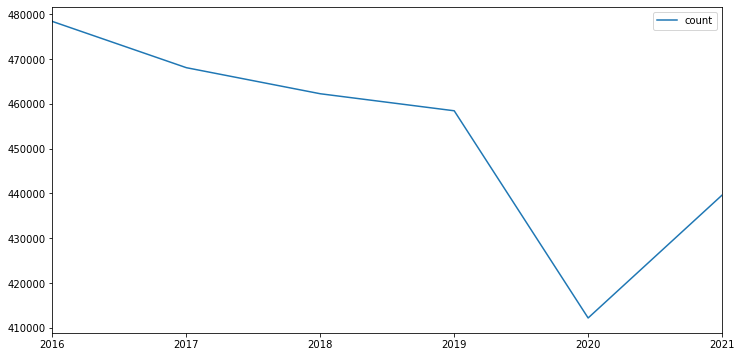

In [6]:
crime_dates['count'].loc["2016":].resample('y').sum().to_frame('count').plot(figsize=(12, 6))

<AxesSubplot:>

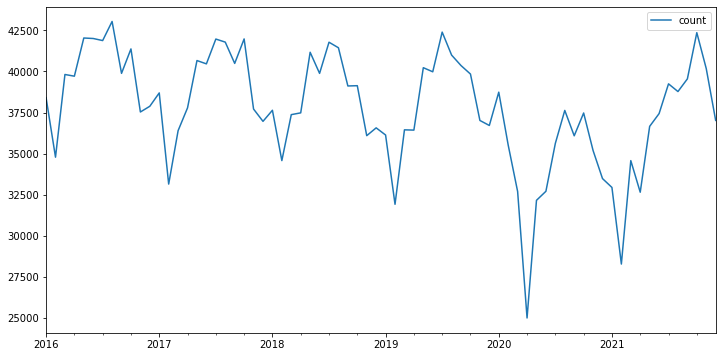

In [7]:
crime_dates['count'].loc["2016":].resample('m').sum().to_frame('count').plot(figsize=(12, 6))

<AxesSubplot:>

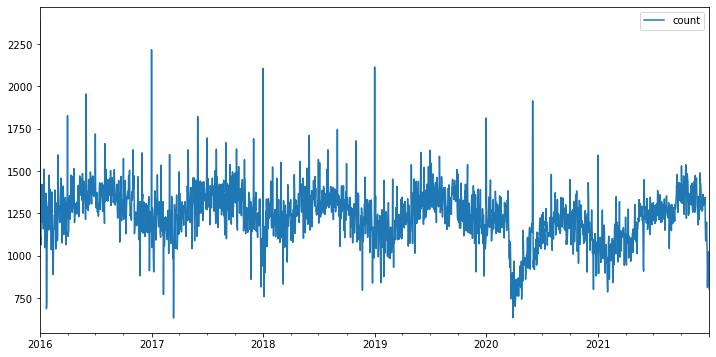

In [8]:
crime_dates['count'].loc["2016":].resample('d').sum().to_frame('count').plot(figsize=(12, 6))

In [9]:
#preparation of initial dataset
crimes = df.index.value_counts().to_frame('Crimes count')
crimes.index.name = 'Date'
crimes = crimes.sort_values(by = 'Date')
crimes = crimes.loc["2016-01-02":]
crimes = crimes.resample('D').sum()
crimes

,Crimes count
Date,
2016-01-02,1204
2016-01-03,1094
2016-01-04,1107
2016-01-05,1064
2016-01-06,1290
...,...
2021-12-27,990
2021-12-28,967
2021-12-29,1023


In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(crimes)
crimes_normalized = scaler.transform(crimes)
crimes_normalized

array([[0.36111111],
       [0.29166667],
       [0.29987374],
       ...,
       [0.24684343],
       [0.21022727],
       [0.10606061]])

In [11]:
#transform data for network
forecast_size = 7
def transform_data(data, length):
    x = []
    y = []
    for i in range(len(data) - length):
        x_data = [val for val in data[i:i+length]]
        x.append(x_data)
        y.append(data[i+length][0])
    return np.array(x), np.array(y)

x, y = transform_data(crimes_normalized, forecast_size)
x.shape, y.shape, x

((2184, 7, 1),
 (2184,),
 array([[[0.36111111],
         [0.29166667],
         [0.29987374],
         ...,
         [0.41540404],
         [0.38005051],
         [0.49810606]],
 
        [[0.29166667],
         [0.29987374],
         [0.27272727],
         ...,
         [0.38005051],
         [0.49810606],
         [0.47853535]],
 
        [[0.29987374],
         [0.27272727],
         [0.41540404],
         ...,
         [0.49810606],
         [0.47853535],
         [0.35606061]],
 
        ...,
 
        [[0.35732323],
         [0.29103535],
         [0.25441919],
         ...,
         [0.18939394],
         [0.2260101 ],
         [0.2114899 ]],
 
        [[0.29103535],
         [0.25441919],
         [0.11363636],
         ...,
         [0.2260101 ],
         [0.2114899 ],
         [0.24684343]],
 
        [[0.25441919],
         [0.11363636],
         [0.18939394],
         ...,
         [0.2114899 ],
         [0.24684343],
         [0.21022727]]]))

In [28]:
#split data for training and testing
x_train, y_train = x[:-500], y[:-500]
x_temp, y_temp = x[-500:], y[-500:]
x_val, y_val = x_temp[:200], y_temp[:200]
x_test, y_test = x_temp[200:], y_temp[200:]
x_val.shape, x_test.shape, x_train.shape

((200, 7, 1), (300, 7, 1), (1684, 7, 1))

In [13]:
from keras.models import Sequential
from keras.layers import *
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.activations import relu, linear
from keras.callbacks import TensorBoard, ModelCheckpoint


mc = ModelCheckpoint('./model', save_best_only=True)
cb = TensorBoard('./logs')

model = Sequential([
    InputLayer((forecast_size, 1)),
    LSTM(88),
    Dense(48, relu),
    Dense(24, relu),
    Dense(1, linear)
])
model.summary()
model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 88)                31680     
                                                                 
 dense (Dense)               (None, 48)                4272      
                                                                 
 dense_1 (Dense)             (None, 24)                1176      
                                                                 
 dense_2 (Dense)             (None, 1)                 25        
                                                                 
Total params: 37,153
Trainable params: 37,153
Non-trainable params: 0
_________________________________________________________________


In [133]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=150, callbacks=[cb, mc])

Epoch 1/150
53/53 [==============================] - ETA: 0s - loss: 0.0243 - root_mean_squared_error: 0.1559

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


53/53 [==============================] - 18s 265ms/step - loss: 0.0243 - root_mean_squared_error: 0.1559 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0687
Epoch 2/150
53/53 [==============================] - 0s 8ms/step - loss: 0.0066 - root_mean_squared_error: 0.0810 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0725
Epoch 3/150
53/53 [==============================] - 0s 8ms/step - loss: 0.0065 - root_mean_squared_error: 0.0806 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0750
Epoch 4/150
51/53 [===========================>..] - ETA: 0s - loss: 0.0066 - root_mean_squared_error: 0.0815

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


53/53 [==============================] - 14s 264ms/step - loss: 0.0066 - root_mean_squared_error: 0.0812 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0676
Epoch 5/150
53/53 [==============================] - 0s 8ms/step - loss: 0.0064 - root_mean_squared_error: 0.0798 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0694
Epoch 6/150
50/53 [===========================>..] - ETA: 0s - loss: 0.0063 - root_mean_squared_error: 0.0796

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


53/53 [==============================] - 17s 319ms/step - loss: 0.0064 - root_mean_squared_error: 0.0798 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0667
Epoch 7/150
53/53 [==============================] - 0s 8ms/step - loss: 0.0064 - root_mean_squared_error: 0.0799 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0711
Epoch 8/150
48/53 [==========================>...] - ETA: 0s - loss: 0.0065 - root_mean_squared_error: 0.0805

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


53/53 [==============================] - 20s 388ms/step - loss: 0.0064 - root_mean_squared_error: 0.0800 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0665
Epoch 9/150
46/53 [=========================>....] - ETA: 0s - loss: 0.0064 - root_mean_squared_error: 0.0797

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


53/53 [==============================] - 24s 460ms/step - loss: 0.0063 - root_mean_squared_error: 0.0792 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0663
Epoch 10/150
53/53 [==============================] - 0s 8ms/step - loss: 0.0064 - root_mean_squared_error: 0.0798 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0687
Epoch 11/150
53/53 [==============================] - 0s 8ms/step - loss: 0.0062 - root_mean_squared_error: 0.0790 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0691
Epoch 12/150
53/53 [==============================] - 1s 10ms/step - loss: 0.0063 - root_mean_squared_error: 0.0794 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0693
Epoch 13/150
53/53 [==============================] - 2s 34ms/step - loss: 0.0063 - root_mean_squared_error: 0.0793 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0668
Epoch 14/150
53/53 [==============================] - 1s 10ms/step - loss: 0.0063 - root_mean_squared_error: 0.0792 - val_loss: 0.0053 - val_root_me

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


53/53 [==============================] - 16s 301ms/step - loss: 0.0062 - root_mean_squared_error: 0.0790 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0660
Epoch 16/150
50/53 [===========================>..] - ETA: 0s - loss: 0.0063 - root_mean_squared_error: 0.0793

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


53/53 [==============================] - 13s 243ms/step - loss: 0.0063 - root_mean_squared_error: 0.0791 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0660
Epoch 17/150
53/53 [==============================] - 0s 8ms/step - loss: 0.0065 - root_mean_squared_error: 0.0804 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0689
Epoch 18/150
53/53 [==============================] - 1s 11ms/step - loss: 0.0061 - root_mean_squared_error: 0.0783 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0714
Epoch 19/150
53/53 [==============================] - 1s 10ms/step - loss: 0.0063 - root_mean_squared_error: 0.0794 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0708
Epoch 20/150
53/53 [==============================] - 0s 9ms/step - loss: 0.0063 - root_mean_squared_error: 0.0791 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0661
Epoch 21/150
53/53 [==============================] - 0s 9ms/step - loss: 0.0062 - root_mean_squared_error: 0.0790 - val_loss: 0.0050 - val_root_mea

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


53/53 [==============================] - 15s 284ms/step - loss: 0.0059 - root_mean_squared_error: 0.0769 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0654
Epoch 30/150
53/53 [==============================] - 0s 8ms/step - loss: 0.0057 - root_mean_squared_error: 0.0758 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0762
Epoch 31/150
53/53 [==============================] - 0s 9ms/step - loss: 0.0059 - root_mean_squared_error: 0.0767 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0688
Epoch 32/150
53/53 [==============================] - 0s 8ms/step - loss: 0.0060 - root_mean_squared_error: 0.0774 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0717
Epoch 33/150
53/53 [==============================] - 0s 8ms/step - loss: 0.0063 - root_mean_squared_error: 0.0792 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0670
Epoch 34/150
53/53 [==============================] - 0s 8ms/step - loss: 0.0059 - root_mean_squared_error: 0.0765 - val_loss: 0.0057 - val_root_mean_

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


53/53 [==============================] - 13s 247ms/step - loss: 0.0057 - root_mean_squared_error: 0.0757 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0652
Epoch 40/150
53/53 [==============================] - 0s 8ms/step - loss: 0.0058 - root_mean_squared_error: 0.0762 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0654
Epoch 41/150
53/53 [==============================] - 0s 9ms/step - loss: 0.0057 - root_mean_squared_error: 0.0755 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0771
Epoch 42/150
53/53 [==============================] - 0s 8ms/step - loss: 0.0059 - root_mean_squared_error: 0.0768 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0703
Epoch 43/150
53/53 [==============================] - 0s 8ms/step - loss: 0.0057 - root_mean_squared_error: 0.0753 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0696
Epoch 44/150
53/53 [==============================] - 0s 8ms/step - loss: 0.0058 - root_mean_squared_error: 0.0759 - val_loss: 0.0048 - val_root_mean_

In [14]:
from keras.models import load_model
loaded_model = load_model('model/')

10/10 [==============================] - 0s 22ms/step
Max difference:  Date
2021-06-01    317.0
dtype: float64


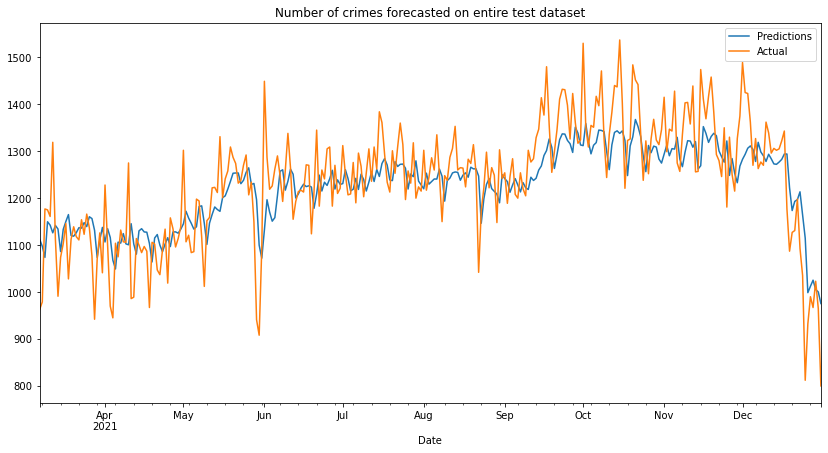

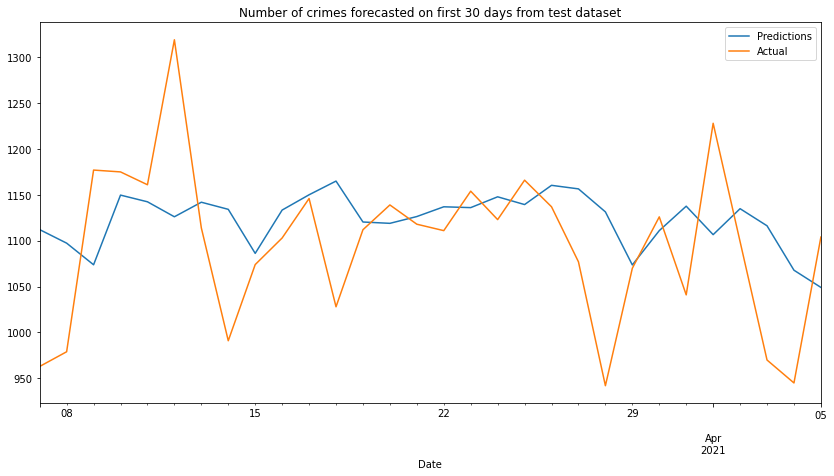

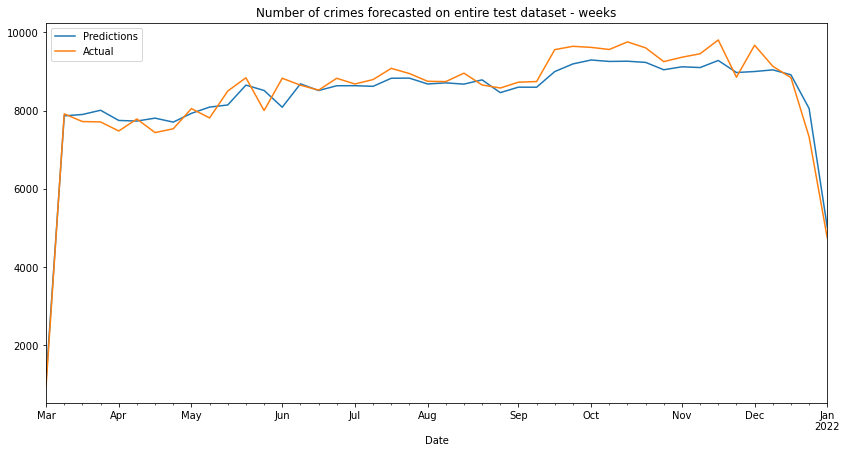

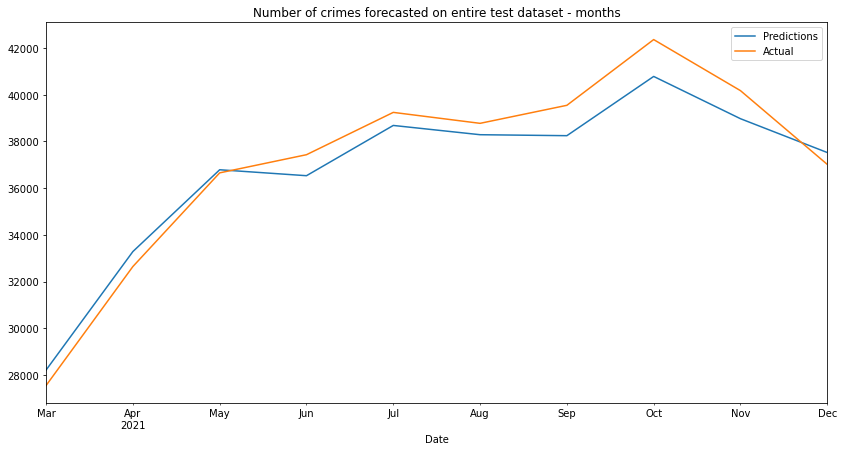

In [67]:
def predict(x, y):
    prediction_normalized = loaded_model.predict(x).flatten()
    predicted = scaler.inverse_transform([prediction_normalized]).reshape(-1, 1).flatten()
    actual = scaler.inverse_transform([y]).reshape(-1, 1).flatten()
    return pd.DataFrame(data={'Predictions': predicted, 'Actual': actual})

result = predict(x_test, y_test)
result.index = crimes.index.values[-300:]
result.index.name = 'Date'
idx_diff_max = (result['Predictions'] - result['Actual']).abs().idxmax()
row_diff_max = result[idx_diff_max: idx_diff_max]
print('Max difference: ', round(abs(row_diff_max['Predictions'] - row_diff_max['Actual'])))
plot1 = result.plot(figsize=(14, 7), title='Number of crimes forecasted on entire test dataset - days')
plot2 = result[:30].plot(figsize=(14, 7), title='Number of crimes forecasted on first 30 days from test dataset')
plot3 = result.resample('W').sum().plot(figsize=(14, 7), title='Number of crimes forecasted on entire test dataset - weeks')
plot4 = result.resample('M').sum().plot(figsize=(14, 7), title='Number of crimes forecasted on entire test dataset - months')

53/53 [==============================] - 1s 14ms/step
Max difference:  Date
2017-12-25    1092.0
dtype: float64


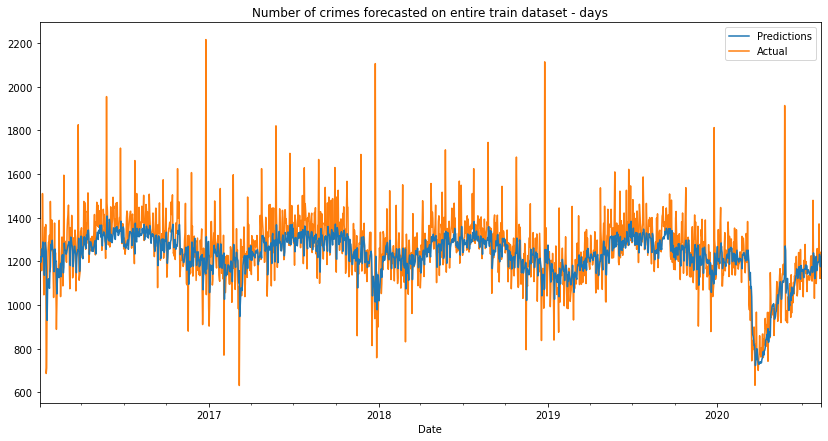

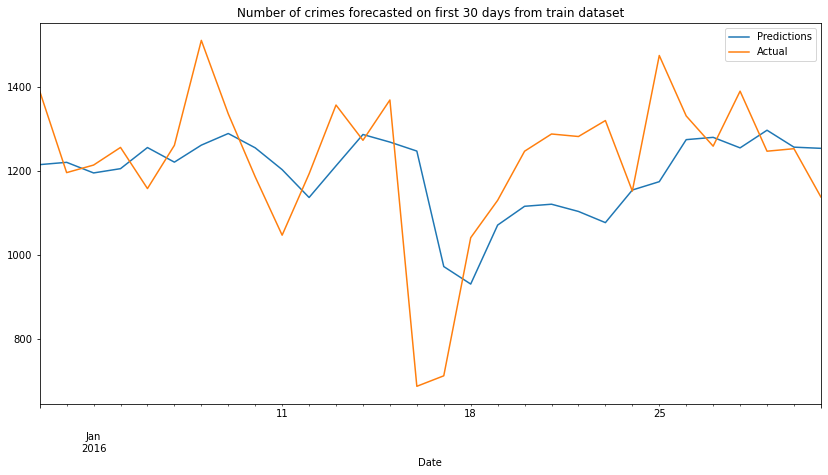

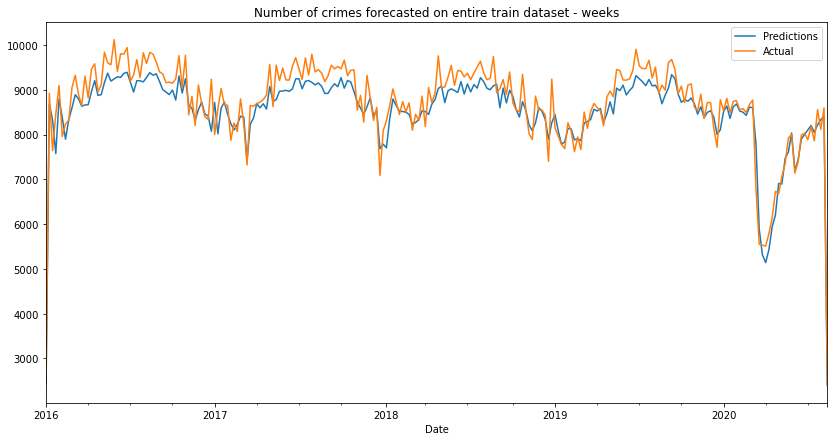

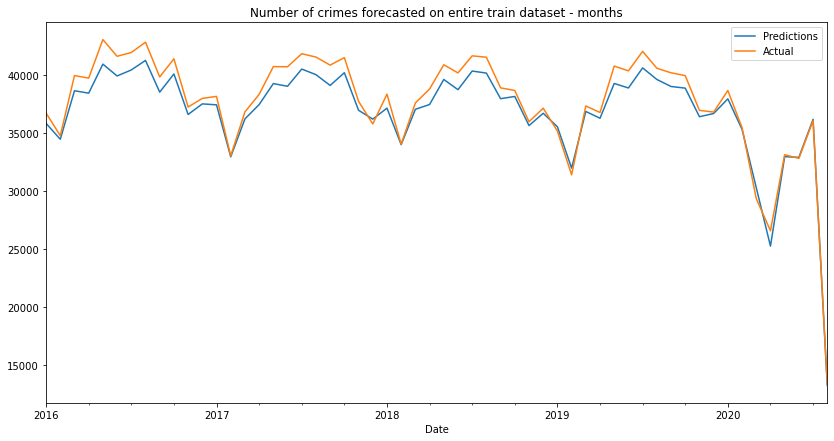

In [79]:
train_result = predict(x_train, y_train)
train_result.index = crimes.index.values[:-500 - forecast_size]
train_result.index.name = 'Date'
idx_diff_max = (train_result['Predictions'] - train_result['Actual']).abs().idxmax()
row_diff_max = train_result[idx_diff_max: idx_diff_max]
print('Max difference: ', round(abs(row_diff_max['Predictions'] - row_diff_max['Actual'])))
plot5 = train_result.plot(figsize=(14, 7), title='Number of crimes forecasted on entire train dataset - days')
plot5.lines[1].zorder=5
plot5.lines[0].zorder=10
plot6 = train_result[:30].plot(figsize=(14, 7), title='Number of crimes forecasted on first 30 days from train dataset')
plot7 = train_result.resample('W').sum().plot(figsize=(14, 7), title='Number of crimes forecasted on entire train dataset - weeks')
plot8 = train_result.resample('M').sum().plot(figsize=(14, 7), title='Number of crimes forecasted on entire train dataset - months')

7/7 [==============================] - 0s 16ms/step
Max difference:  Date
2021-01-01    568.0
dtype: float64


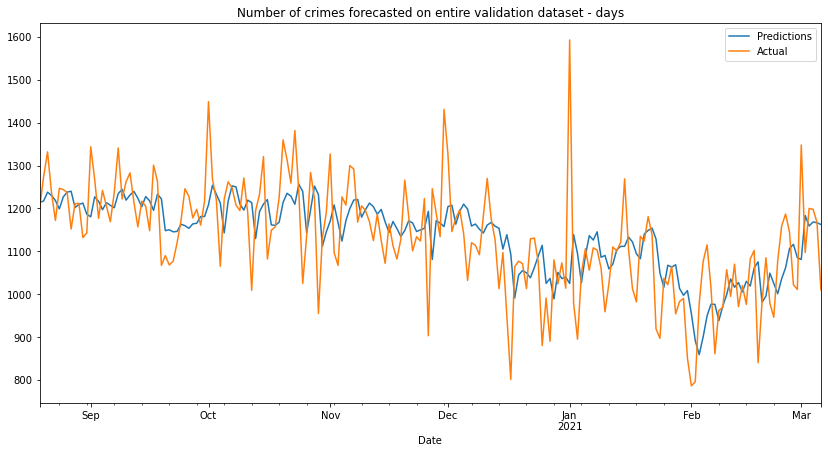

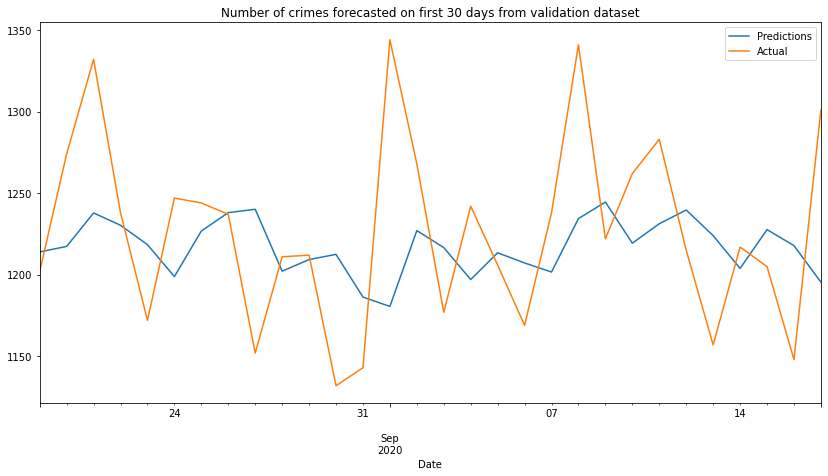

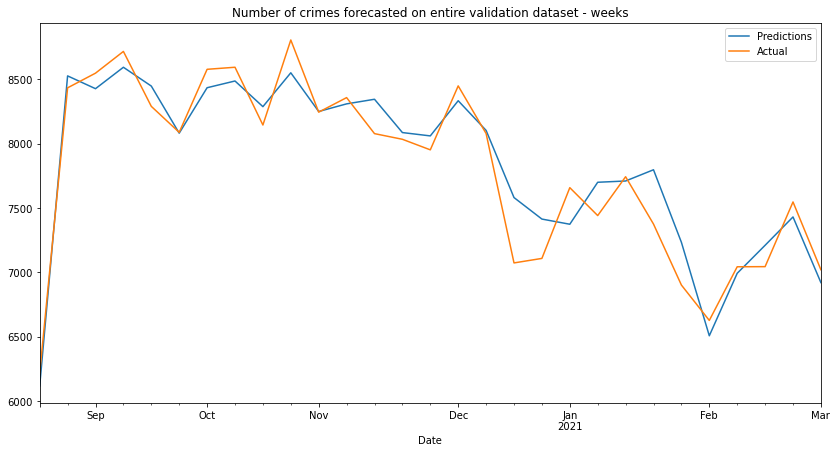

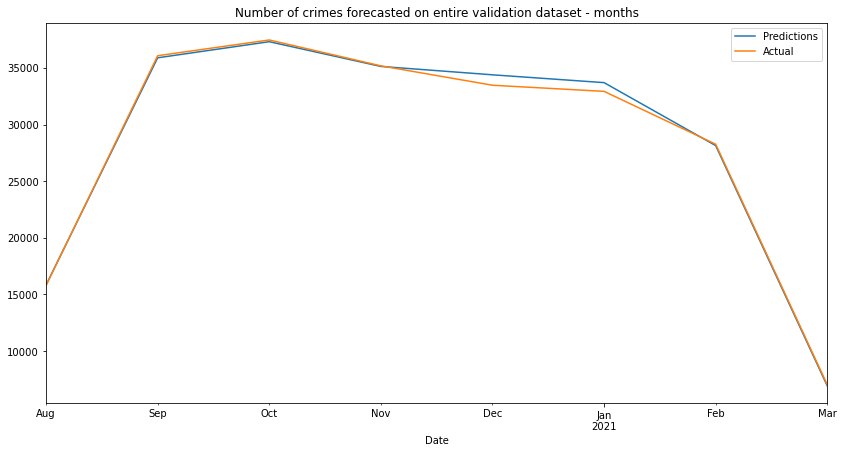

In [73]:

val_result = predict(x_val, y_val)
val_result.index = crimes.index.values[-500:-300]
val_result.index.name = 'Date'
idx_diff_max = (val_result['Predictions'] - val_result['Actual']).abs().idxmax()
row_diff_max = val_result[idx_diff_max: idx_diff_max]
print('Max difference: ', round(abs(row_diff_max['Predictions'] - row_diff_max['Actual'])))
plot9 = val_result.plot(figsize=(14, 7), title='Number of crimes forecasted on entire validation dataset - days')
plot10 = val_result[:30].plot(figsize=(14, 7), title='Number of crimes forecasted on first 30 days from validation dataset')
plot11 = val_result.resample('W').sum().plot(figsize=(14, 7), title='Number of crimes forecasted on entire validation dataset - weeks')
plot12 = val_result.resample('M').sum().plot(figsize=(14, 7), title='Number of crimes forecasted on entire validation dataset - months')